In [130]:
import pandas as pd
import numpy as np
import pandas as pd
import statistics as stats
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from datetime import time, datetime, timedelta
import math
import matplotlib.ticker as ticker
import statistics
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb
import warnings
import time
from sklearn.model_selection import GridSearchCV
import json
warnings.filterwarnings('ignore')
os.chdir("C:/Users/boypa/OneDrive - The University of Auckland/INFOSYS 722/Project/Assignment 3")

***Data Retrieval***

In [ ]:
#function from TP to time
def tp_to_time(n):
    hours = (n - 1) // 2
    minutes = 30 * ((n - 1) % 2)
    t = time(hour=hours, minute=minutes)
    return t

##take data from price and volume data, change the year accordingly 
year_list=['2021','2022','2023']
TP_list = [f'TP{e}' for e in range(1,49)]
gen = pd.DataFrame(columns=['Date']+TP_list)
dir = "C:/Users/boypa/OneDrive - The University of Auckland/Project/Nodal Data"
year='2023'
file_unavail_list=[]
file_avail_list=[]
day_number=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31']
month_number=['01','02','03','04','05','06','07','08','09','10','11','12']
raw_load_df = pd.DataFrame(columns=['Date', 'time', 'TP', 'Load','Datetime'])
for i in range(0,12):
    for j in range(0,31):
        filename = f'{year}{month_number[i]}{day_number[j]}_DispatchNodalPricesAndVolumes.csv'
        file_path= os.path.join(dir, filename)
        datestring = f'{day_number[j]}/{month_number[i]}/{year}'
        if os.path.exists(file_path):
            file_avail_list.append(filename)
            data=pd.read_csv(file_path)
            entries = data[(data['PointOfConnectionCode']=='HOB1101')&(data['TradingPeriodNumber'].isin(list(range(1,49))))].groupby('TradingPeriodNumber').agg({'LoadMegawatts':'mean'}).reset_index()
            entries = entries.rename(columns={'TradingPeriodNumber':'TP','LoadMegawatts':'Load'})
            if len(entries)==48 :
                entries['Date'] = pd.to_datetime([datestring]*len(entries), dayfirst=True)
                entries['time'] = entries.apply(lambda row:tp_to_time(row['TP']), axis=1)
                entries['Datetime'] = entries.apply(lambda row:row['Date']+timedelta(hours=row['time'].hour,minutes=row['time'].minute), axis=1)                        
                raw_load_df = pd.concat([raw_load_df,entries],ignore_index=True, axis=0)
            elif len(entries)==0:
                tp_unavail = list(range(1,49))
                nfill = len(tp_unavail)
                date_list = list(pd.to_datetime([datestring]*nfill, dayfirst=True))
                time_list = [tp_to_time(e) for e in tp_unavail]
                hour_list = [e.hour for e in time_list]
                minute_list = [e.minute for e in time_list]
                dt_list = [date_list[e]+timedelta(hours=hour_list[e],minutes=minute_list[e]) for e in range(0,len(tp_unavail))]
                add_entries = pd.DataFrame({'Date':date_list,
                               'TP':tp_unavail,'time':time_list,'Datetime':dt_list})
                entries = pd.concat([entries,add_entries],ignore_index=True, axis=0)
                entries = entries.sort_values(by='TP')
                raw_load_df = pd.concat([raw_load_df,entries],ignore_index=True, axis=0)
            else:
                entries['Date'] = pd.to_datetime([datestring]*len(entries), dayfirst=True)
                entries['time'] = entries.apply(lambda row:tp_to_time(row['TP']), axis=1)
                entries['Datetime'] = entries.apply(lambda row:row['Date']+timedelta(hours=row['time'].hour,minutes=row['time'].minute), axis=1)                   
                tpavail = list(entries['TP'])
                tplist=list(range(1,49))
                tp_unavail = list(set(tplist)-set(tpavail))
                nfill = len(tp_unavail)
                date_list = list(pd.to_datetime([datestring]*nfill,dayfirst=True))
                time_list = [tp_to_time(e) for e in tp_unavail]
                hour_list = [e.hour for e in time_list]
                minute_list = [e.minute for e in time_list]
                dt_list = [date_list[e]+timedelta(hours=hour_list[e],minutes=minute_list[e]) for e in range(0,len(tp_unavail))]
                add_entries = pd.DataFrame({'Date':date_list,
                               'TP':tp_unavail,'time':time_list,'Datetime':dt_list})
                entries = pd.concat([entries,add_entries],ignore_index=True, axis=0)
                entries = entries.sort_values(by='TP')
                raw_load_df = pd.concat([raw_load_df,entries],ignore_index=True, axis=0)                    
        else:
            file_unavail_list.append(filename)
raw_load_df.to_csv(f'dataset/raw_load_df_{year}.csv')

In [59]:
#combine all files
raw_load_df_2021 = pd.read_csv('dataset/raw_load_df_2021.csv')
raw_load_df_2022 = pd.read_csv('dataset/raw_load_df_2022.csv')
raw_load_df_2023 = pd.read_csv('dataset/raw_load_df_2023.csv')
raw_load_df = pd.concat([raw_load_df_2021,raw_load_df_2022,raw_load_df_2023],ignore_index=True, axis=0)
#ensure datetime format
raw_load_df['Date'] = pd.to_datetime(raw_load_df['Date'],errors='coerce')
raw_load_df['Datetime'] = pd.to_datetime(raw_load_df['Datetime'],errors='coerce')
raw_load_df.to_csv('dataset/raw_load_df.csv')
raw_load_df = raw_load_df.drop(columns ='Unnamed: 0')

In [60]:
#Add Holiday Table
holiday_2020 = ['01/01/2020','02/01/2020','27/01/2020','06/02/2020','10/04/2020','13/04/2020','25/04/2020','01/06/2020','26/10/2020','25/12/2020','26/12/2020']
holiday_2021 = ['01/01/2021','02/01/2021','04/01/2021','08/02/2021','2/04/2021','5/04/2021','26/04/2021','07/06/2021','25/10/2021','25/12/2021','26/12/2021']
holiday_2022 = ['01/01/2022','03/01/2022','4/01/2022','06/02/2022','15/04/2022','18/04/2022','25/04/2022','06/06/2022','24/06/2022','26/09/2022','24/10/2022','25/12/2022','26/12/2022']
holiday_2023 = ['01/01/2023','02/01/2023','03/01/2023','06/02/2023','7/04/2023','10/04/2023','25/04/2023','05/06/2023','14/07/2023','23/10/2023','25/12/2023','26/12/2023']
holiday_2024 = ['01/01/2024','02/01/2024','29/01/2024','06/02/2024','29/03/2024','01/04/2024','25/04/2024','03/06/2024','28/06/2024','28/10/2024','25/12/2024','26/12/2024']
holiday_dates = holiday_2020 + holiday_2021 + holiday_2022 + holiday_2023 + holiday_2024
holiday_dates = pd.to_datetime(holiday_dates, format="%d/%m/%Y")

In [61]:
#Feature addition
raw_load_df['Month'] = raw_load_df['Date'].dt.month
raw_load_df['Day_of_week'] = raw_load_df['Date'].dt.dayofweek
raw_load_df['Is_weekend'] = raw_load_df['Date'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)
raw_load_h_df = raw_load_df.copy()
raw_load_h_df['Is_holiday'] = raw_load_h_df['Date'].apply(lambda x: 1 if x in holiday_dates else 0)
raw_load_filled_df = raw_load_h_df.copy()

In [62]:
#Fill NA load values and reduce decimal point
raw_load_filled_df['Load'] = raw_load_h_df.groupby(['Month','Day_of_week', 'Is_weekend', 'Is_holiday', 'TP'])['Load'].transform(lambda x: x.fillna(x.mean()))
raw_load_filled_df['Load'] = round(raw_load_filled_df['Load'],2)

In [63]:
# Load weather data
#---weather table---#
#to panda datetime
auckland_weather_DP = pd.read_csv('C:/Users/boypa/OneDrive - The University of Auckland/Project/Data/Weather/auckland_weather_DP_output1.csv')
auckland_weather_DP['datetime'] = pd.to_datetime(auckland_weather_DP['datetime'], format='%Y-%m-%d %H:%M:%S')
#remove duplicate
auckland_weather_DP_r = auckland_weather_DP.drop_duplicates(subset=['datetime'])
#duplicate each row and add TP column to make it half hourly
auckland_weather_DP_r_copy = auckland_weather_DP_r.copy()
auckland_weather_DP_r_copy['datetime'] = pd.to_datetime(auckland_weather_DP_r_copy['datetime']) + pd.Timedelta(minutes=30)
auckland_weather = pd.concat([auckland_weather_DP_r_copy, auckland_weather_DP_r]).sort_index(kind='merge')
auckland_weather['TP'] = ((auckland_weather['datetime'].dt.hour * 2) + (auckland_weather['datetime'].dt.minute / 30)).astype(int) + 1
auckland_weather = auckland_weather.sort_values('datetime').reset_index(drop=True)
auckland_weather['Date'] = pd.to_datetime(auckland_weather['datetime'].dt.date)
auckland_weather_2020to2023 = auckland_weather[auckland_weather['Date'].dt.year<=2023]

In [64]:
#check time index consistency load data
raw_load_filled_df_c = raw_load_filled_df.copy()
raw_load_filled_df_shift = raw_load_filled_df_c.shift(-1)
raw_load_filled_df_c['shift'] = raw_load_filled_df_shift['Datetime']
raw_load_filled_df_c['diff'] = raw_load_filled_df_c.apply(lambda row:(row['shift']-row['Datetime']).total_seconds(), axis=1)
raw_load_filled_df_c[raw_load_filled_df_c['diff']!=1800]

,Date,time,TP,Load,Datetime,Month,Day_of_week,Is_weekend,Is_holiday,shift,diff
52559,2023-12-31,23:30:00,48,24.77,2023-12-31 23:30:00,12,6,1,0,NaT,NaN


In [65]:
#check time index consistency load data
auckland_weather_2020to2023_c = auckland_weather_2020to2023.copy()
auckland_weather_2020to2023_shift = auckland_weather_2020to2023_c.shift(-1)
auckland_weather_2020to2023_c['shift'] = auckland_weather_2020to2023_shift['datetime']
auckland_weather_2020to2023_c['diff'] = auckland_weather_2020to2023_c.apply(lambda row:(row['shift']-row['datetime']).total_seconds(), axis=1)
auckland_weather_2020to2023_c[auckland_weather_2020to2023_c['diff']!=1800]

,datetime,temp,humidity,Month,Day,Hour,TP,Date,shift,diff
12867,2021-09-26 01:30:00,13.9,88.38,9,26,1,4,2021-09-26,2021-09-26 03:00:00,5400.0
30337,2022-09-25 01:30:00,14.1,79.27,9,25,1,4,2022-09-25,2022-09-25 03:00:00,5400.0
47807,2023-09-24 01:30:00,15.5,97.61,9,24,1,4,2023-09-24,2023-09-24 03:00:00,5400.0
52553,2023-12-31 23:30:00,19.5,92.55,12,31,23,48,2023-12-31,NaT,NaN


In [66]:
#Make Sure the same datetime length
auckland_weather_2020to2023_tm = pd.merge(raw_load_filled_df['Datetime'],auckland_weather_2020to2023, 
                                                             left_on='Datetime', right_on = 'datetime', 
                                                             how = 'outer')
auckland_weather_2020to2023_tm = auckland_weather_2020to2023_tm.drop(columns = ['datetime'])    
auckland_weather_2020to2023_tm.bfill(inplace=True)

In [67]:
raw_load_filled_df.columns

Index(['Date', 'time', 'TP', 'Load', 'Datetime', 'Month', 'Day_of_week',
       'Is_weekend', 'Is_holiday'],
      dtype='object')

In [68]:
auckland_weather_2020to2023_tm.columns

Index(['Datetime', 'temp', 'humidity', 'Month', 'Day', 'Hour', 'TP', 'Date'], dtype='object')

In [69]:
#Merge Load and Weather data
main_df = pd.merge(raw_load_filled_df, auckland_weather_2020to2023_tm[['Datetime','temp','humidity']], on='Datetime', how='left').reset_index(drop=True)
main_df.head()

,Date,time,TP,Load,Datetime,Month,Day_of_week,Is_weekend,Is_holiday,temp,humidity
0,2021-01-01,00:00:00,1,23.42,2021-01-01 00:00:00,1,4,0,1,16.0,86.88
1,2021-01-01,00:30:00,2,23.41,2021-01-01 00:30:00,1,4,0,1,16.0,86.88
2,2021-01-01,01:00:00,3,22.64,2021-01-01 01:00:00,1,4,0,1,16.4,90.02
3,2021-01-01,01:30:00,4,22.13,2021-01-01 01:30:00,1,4,0,1,16.4,90.02
4,2021-01-01,02:00:00,5,22.24,2021-01-01 02:00:00,1,4,0,1,15.7,90.02


In [23]:
#Scaling data (example, should use it after splitting)
scaler = MinMaxScaler(feature_range=(0, 1)) 
df_scaled = main_df[['TP', 'Load','Month', 'Day_of_week',
       'Is_weekend', 'Is_holiday', 'temp', 'humidity']]
scaler.fit(df_scaled)
df_scaled = scaler.transform(df_scaled)
pd.DataFrame(df_scaled, columns=['TP_scaled','Load_scaled','Month_scaled', 'Day_of_week_scaled',
       'Is_weekend_scaled', 'Is_holiday_scaled', 'temp_scaled', 'humidity_scaled']).head()


,TP_scaled,Load_scaled,Month_scaled,Day_of_week_scaled,Is_weekend_scaled,Is_holiday_scaled,temp_scaled,humidity_scaled
0,0.000000,0.327873,0.0,0.666667,0.0,1.0,0.507692,0.817372
1,0.021277,0.327733,0.0,0.666667,0.0,1.0,0.507692,0.817372
2,0.042553,0.316954,0.0,0.666667,0.0,1.0,0.523077,0.861080
3,0.063830,0.309814,0.0,0.666667,0.0,1.0,0.523077,0.861080
4,0.085106,0.311354,0.0,0.666667,0.0,1.0,0.496154,0.861080


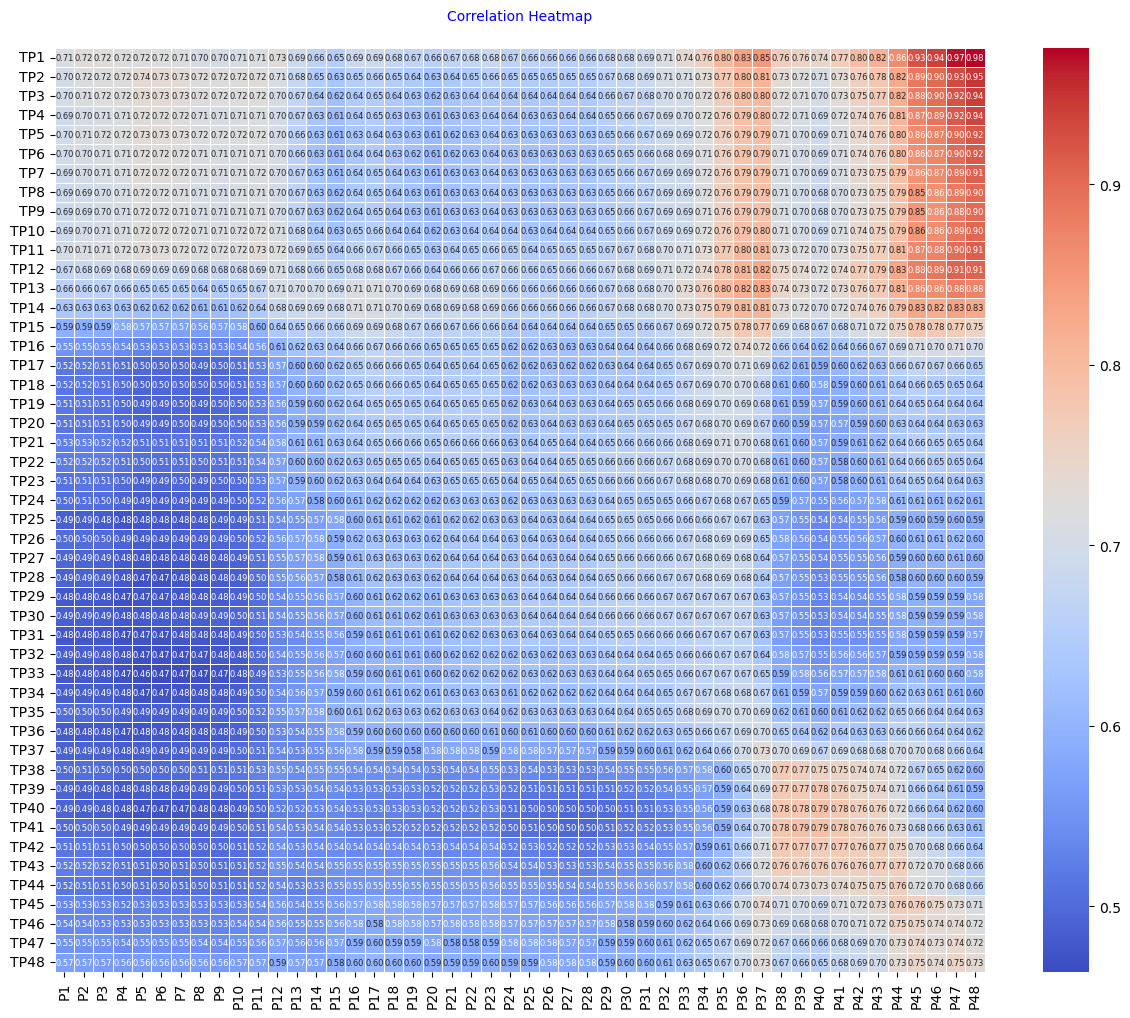

In [70]:
#Add time-lag featue
#pivot wider on TP first, we have 1 row for one day
main_TP_wide_df =  main_df.pivot(index='Date', columns='TP', values='Load')
main_TP_wide_df.columns = [f'TP{col}' for col in main_TP_wide_df.columns]
main_TP_wide_shift_df = main_TP_wide_df.shift(1)
main_TP_wide_shift_df.columns = [f'P{col+1}' for col in range(0,len(main_TP_wide_shift_df.columns))]
main_TP_future_df = pd.concat([main_TP_wide_df,main_TP_wide_shift_df],axis=1)

#Corr heatmap 
cormat = main_TP_future_df.corr()
cormat = cormat[[f'P{col}' for col in range(1,49)]].iloc[range(0,48)]
plt.figure(figsize=(15, 12))  # Optional: Adjusts the size of the heatmap
sns.heatmap(cormat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar=True, annot_kws={'size':6})
plt.title('Correlation Heatmap', fontsize=10, color='blue', pad=20)
plt.xticks(rotation=90)
plt.show()

In [71]:
#Add Is_holiday_previous feature
main_df_c_ih = main_df[['Datetime','Is_holiday']].set_index('Datetime').shift(48)
main_df_c_ih.iloc[range(48)] = 0
main_df_c_ih['Is_holiday'] = main_df_c_ih['Is_holiday'].astype(int)
main_df_c_ih = main_df_c_ih.rename(columns={'Is_holiday':'Is_holiday_prev'}).reset_index().drop(columns='Datetime')
main_df = pd.concat([main_df, main_df_c_ih],axis=1)

In [72]:
#Pivot on P
main_df_p = main_df
main_df_wide_TP = main_df.pivot(index='Date', columns='TP', values='Load')
main_df_wide_TP.columns = [f'TP{col}' for col in main_df_wide_TP.columns]

In [73]:
#Create Wide Dataframe For multiple predictions
#Pivot on TP
main_df_wide_TP = main_df.pivot(index='Date', columns='TP', values='Load')
main_df_wide_TP.columns = [f'TP{col}' for col in main_df_wide_TP.columns]
main_df_wide_TP = main_df_wide_TP.reset_index()
#Pivot on P
main_df_P =  main_df_wide_TP.set_index('Date').shift(1).reset_index()
main_df_P = main_df_P.rename(columns={f'TP{e}':f'P{e}' for e in range(1,49)})
#Pivot on temp
main_df_wide_temp = main_df.pivot(index='Date', columns='TP', values='temp')
main_df_wide_temp.columns = [f'temp{col}' for col in main_df_wide_temp.columns]
main_df_wide_temp = main_df_wide_temp.reset_index()
#Pivot on humidity
main_df_wide_hum = main_df.pivot(index='Date', columns='TP', values='humidity')
main_df_wide_hum.columns = [f'hum{col}' for col in main_df_wide_hum.columns]
main_df_wide_hum = main_df_wide_hum.reset_index()

#merge TP,P,temp,hum columnwise
main_daily_df = pd.merge(main_df_wide_TP,main_df_P,how='left',on='Date')
main_daily_df = pd.merge(main_daily_df,main_df_wide_temp,how='left',on='Date')
main_daily_df = pd.merge(main_daily_df,main_df_wide_hum,how='left',on='Date')
main_daily_df = pd.merge(main_daily_df,main_df[['Date','Month','Day_of_week',
                                                'Is_holiday','Is_holiday_prev']][main_df['TP']==1],
                         how='left',on='Date')

***Run Model use Param from Gridsearch***

In [247]:
#Model Function
#Good value : max_depth=3, eta=0.1, reg_lambda=25

def model_xgb_1(df,split_at,feature_drop):
    train_idx = df[df['Date']<=pd.to_datetime(split_at, format='%d/%m/%Y')].index
    test_idx = df[df['Date']>pd.to_datetime(split_at, format='%d/%m/%Y')].index
    train_y = df['Load'].iloc[train_idx]
    test_y = df['Load'].iloc[test_idx]
    train_x = df.drop(columns=['Load','Date']+feature_drop).iloc[train_idx]
    test_x = df.drop(columns=['Load','Date']+feature_drop).iloc[test_idx]
    #Train
    reg = xgb.XGBRegressor(n_estimators=100, enable_categorical=True, max_depth=bestparams[f'{i}']['max_depth'], 
                           eta=bestparams[f'{i}']['eta'], reg_lambda=25)
    reg.fit(train_x, train_y, verbose = False)
    #Test
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    train_df['pred_train'] = reg.predict(train_x)
    test_df['pred'] = reg.predict(test_x)
    train_pred = train_df[['Date','pred_train']]
    test_pred = test_df[['Date','pred']]
    f_importance = reg.feature_importances_
    return train_pred, test_pred, f_importance

In [252]:
#Create DF for each TP , train, test, put in main DF
full_feature = ['timelag','temp','hum','Month','Day_of_week','Is_holiday','Is_holiday_prev']
feature_drop = []
feature_used = [e for e in full_feature if e not in set(feature_drop)] 
start_time = time.time()
feature_importances = pd.DataFrame({e:[0]*48 for e in feature_used})
feature_importances.index = list(range(1,49))
train_pred_df = pd.DataFrame(columns=['Date','pred_train','TP'])
test_pred_df = pd.DataFrame(columns=['Date','pred','TP'])
#open previously determined bestparams
with open('bestparams.json', 'r') as json_file:
    bestparams = json.load(json_file)
for i in range(1,49):
    timelag_used = 48 if i<=16 else i
    df =  main_daily_df[['Date',f'TP{i}',f'P{timelag_used}',f'temp{i}',f'hum{i}','Month'
                                    ,'Day_of_week','Is_holiday','Is_holiday_prev']]
    df =  df.rename(columns={f'TP{i}':'Load',f'P{timelag_used}':'timelag',
                                                   f'temp{i}':'temp',f'hum{i}':'hum'})
    #designate categorical and boolean features
    df['Month'] = df['Month'].astype("category")
    df['Day_of_week'] = df['Day_of_week'].astype("category")
    df['Is_holiday'] = df['Is_holiday'].astype(bool)
    df['Is_holiday_prev'] = df['Is_holiday_prev'].astype(bool)
    #Do train and test
    split_at = '31/12/2022'
    train_pred,test_pred,f_importance = model_xgb_1(df,split_at,feature_drop)
    train_pred['TP'] = i
    test_pred['TP'] = i
    #Gather train and test pred
    train_pred_df = pd.concat([train_pred_df,train_pred],axis=0)
    test_pred_df = pd.concat([test_pred_df,test_pred],axis=0)
    #Gather feature importances
    feature_importances.loc[i] = list(f_importance)

#Merge to main DF, Create Error Meas Columns
main_df_pred = main_df.copy()
train_idx = main_df_pred[main_df_pred['Date']<=split_at].index
test_idx = main_df_pred[main_df_pred['Date']>split_at].index
main_df_pred = pd.merge(main_df_pred,train_pred_df,on=['Date','TP'],how='left')
main_df_pred = pd.merge(main_df_pred,test_pred_df,on=['Date','TP'],how='left')
main_df_pred['mape_train'] = None
main_df_pred['mape_test'] = None
main_df_pred['mae_train'] = None
main_df_pred['mae_test'] = None
main_df_pred['mape_train'].iloc[train_idx]=np.abs((main_df_pred['pred_train'].iloc[train_idx] - main_df_pred['Load'].iloc[train_idx])) / main_df_pred['Load'].iloc[train_idx]
main_df_pred['mape_test'].iloc[test_idx]=np.abs((main_df_pred['pred'].iloc[test_idx] - main_df_pred['Load'].iloc[test_idx])) / main_df_pred['Load'].iloc[test_idx]
main_df_pred['mae_train'].iloc[train_idx]=np.abs((main_df_pred['pred_train'].iloc[train_idx] - main_df_pred['Load'].iloc[train_idx])) 
main_df_pred['mae_test'].iloc[test_idx]=np.abs((main_df_pred['pred'].iloc[test_idx] - main_df_pred['Load'].iloc[test_idx]))

#Error Measurements Summary
mse_test = mean_squared_error(main_df_pred['Load'].iloc[test_idx], main_df_pred['pred'].iloc[test_idx])
mse_train = mean_squared_error(main_df_pred['Load'].iloc[train_idx], main_df_pred['pred_train'].iloc[train_idx])
mape_test = main_df_pred['mape_test'].mean()
mape_train = main_df_pred['mape_train'].mean()
mae_test = main_df_pred['mae_test'].mean()
mae_train = main_df_pred['mae_train'].mean()
mape_test_p15 = (main_df_pred['mape_test'].iloc[test_idx]<0.15).mean()
mape_train_p15 = (main_df_pred['mape_train'].iloc[train_idx]<0.15).mean()
run_duration = time.time()-start_time

In [253]:
feature_used

['timelag',
 'temp',
 'hum',
 'Month',
 'Day_of_week',
 'Is_holiday',
 'Is_holiday_prev']

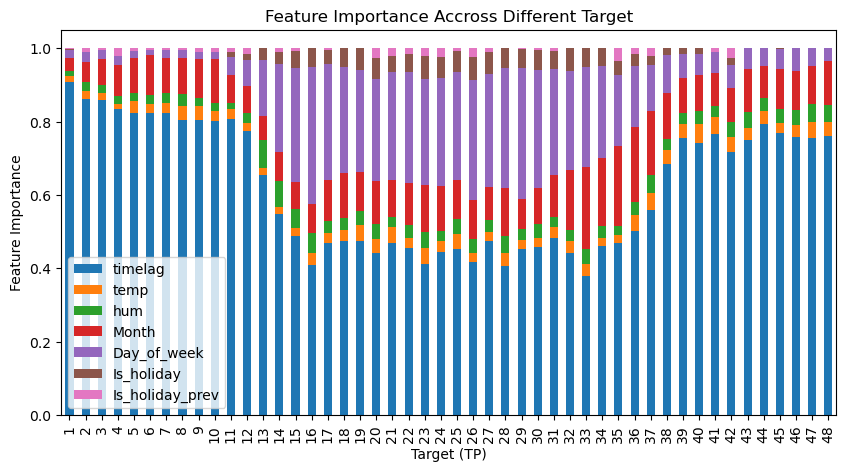

In [254]:
ax = feature_importances.plot.bar(stacked=1, figsize=(10, 5))
plt.title('Feature Importance Accross Different Target')
plt.xlabel('Target (TP)')
plt.ylabel('Feature Importance')
plt.show()

***Check Params with Gridsearch***

In [ ]:
bestparams={e:[] for e in range(1,49)}
for i in range(1,49) :
    timelag_used = 48 if i<=16 else i
    df =  main_daily_df[['Date',f'TP{i}',f'P{timelag_used}',f'temp{i}',f'hum{i}','Month'
                                        ,'Day_of_week','Is_holiday','Is_holiday_prev']]
    df =  df.rename(columns={f'TP{i}':'Load',f'P{timelag_used}':'timelag',
                                                   f'temp{i}':'temp',f'hum{i}':'hum'})
    #designate categorical and boolean features
    df['Month'] = df['Month'].astype("category")
    df['Day_of_week'] = df['Day_of_week'].astype("category")
    df['Is_holiday'] = df['Is_holiday'].astype(bool)
    #Do train and test
    split_at = '31/12/2022'
    train_idx = df[df['Date']<=pd.to_datetime(split_at, format='%d/%m/%Y')].index
    test_idx = df[df['Date']>pd.to_datetime(split_at, format='%d/%m/%Y')].index
    train_y = df['Load'].iloc[train_idx]
    test_y = df['Load'].iloc[test_idx]
    train_x = df.drop(columns=['Load','Date']).iloc[train_idx]
    test_x = df.drop(columns=['Load','Date']).iloc[test_idx]
    reg = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True)  
    param_grid = {
        'eta': [0.1, 0.2, 0.3],      
        'max_depth': [3, 6, 10],      
        'lambda': [1, 5, 25]        
        }   
    grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, 
                               scoring='neg_mean_squared_error', cv=3, verbose=1)     
    grid_search.fit(train_x, train_y, verbose = False)
    bestparams[i] =  grid_search.best_params_     
#save best param to json    
with open('bestparams.json', 'w') as json_file:
    json.dump(bestparams, json_file)

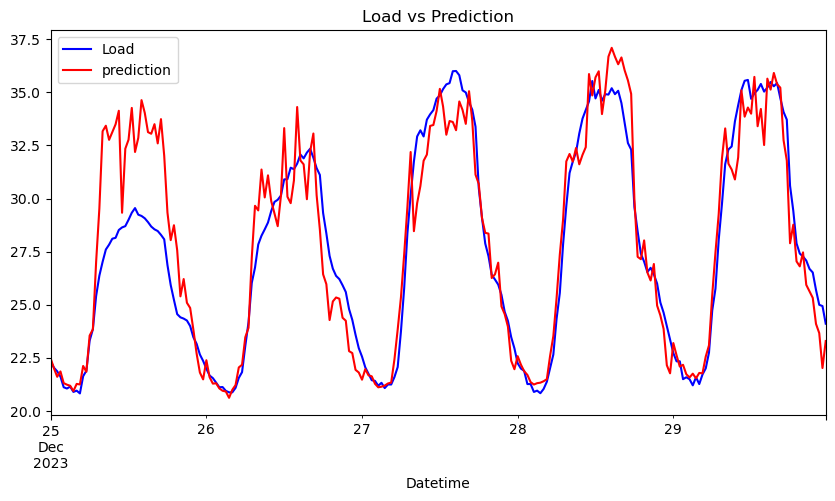

In [277]:
plotrange= range(main_df_pred[main_df_pred['Date']=='25/12/2023'].index[0],main_df_pred[main_df_pred['Date']=='25/12/2023'].index[0]+48*5)
plotrange = list(plotrange)
main_df_pred.set_index('Datetime').iloc[plotrange]['Load'].plot(style='b', figsize=(10,5), label = 'Load')
main_df_pred.set_index('Datetime').iloc[plotrange]['pred'].plot(style='r', figsize=(10,5), label = 'prediction')
plt.title('Load vs Prediction')
plt.legend()

***Visualization for Ch 8***

<Axes: xlabel='TP', ylabel='pred'>

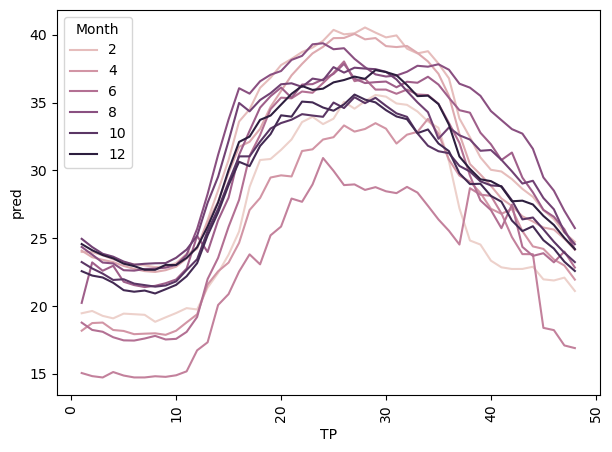

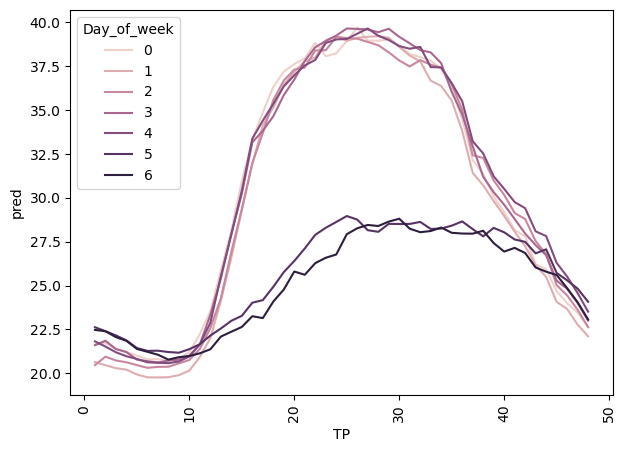

In [266]:
# Check Result of DM
#TP and Load
plt.figure(figsize=(7,5))
plt.xticks(rotation=90)
sns.lineplot(x='TP', y='pred', data=main_df_pred, hue='Month', ci=None)

#----------------------------------------------#
#Day of the week and Load
plt.figure(figsize=(7,5))
plt.xticks(rotation=90)
sns.lineplot(x='TP', y='pred', data=main_df_pred, hue='Day_of_week', ci=None)


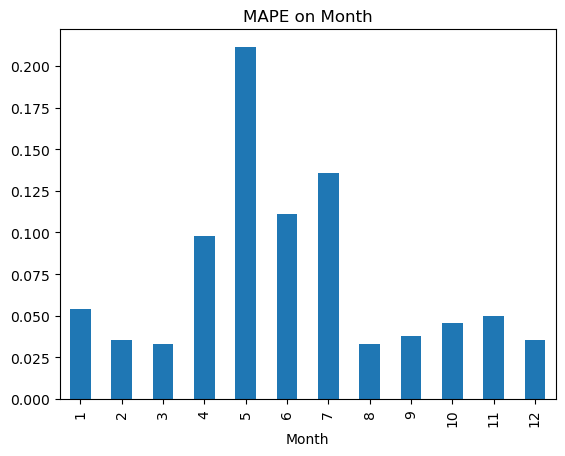

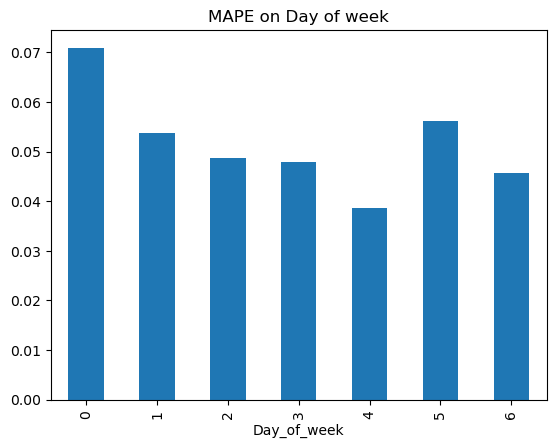

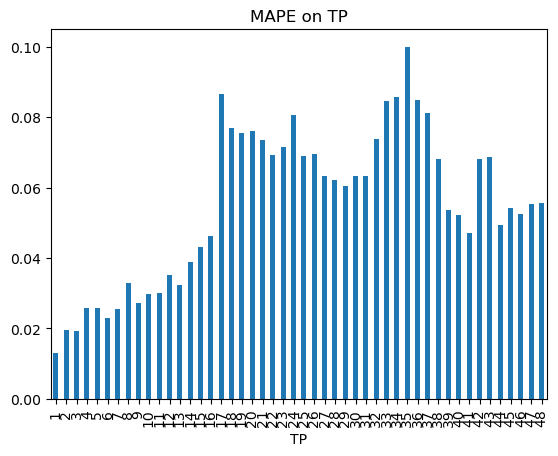

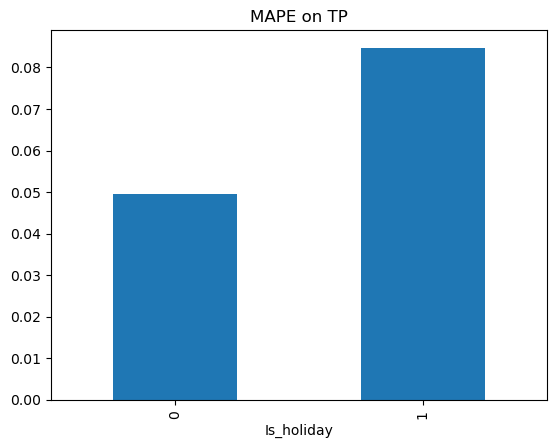

In [284]:
# Error Measurements
#TP and Load
main_df_pred.groupby('Month')['mape_test'].median().plot(kind='bar', x='Month',y='mape_test', title='MAPE on Month' )
plt.show()
main_df_pred.groupby('Day_of_week')['mape_test'].median().plot(kind='bar', x='Day_of_week',y='mape_test', title='MAPE on Day of week' )
plt.show()
main_df_pred.groupby('TP')['mape_test'].median().plot(kind='bar', x='TP',y='mape_test', title='MAPE on TP' )
plt.show()
main_df_pred.groupby('Is_holiday')['mape_test'].median().plot(kind='bar', x='Is_holiday',y='mape_test', title='MAPE on TP' )
plt.show()

In [279]:
main_df_pred[main_df_pred['Is_holiday']==1]['mape_test'].mean()

0.49336954413206385